In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os
import shutil

zip_path = '/content/drive/MyDrive/plant_disease_project/plantdisease.zip'
temp_dir = '/content/temp_extracted'
target_dir = '/content/drive/MyDrive/plant_disease_project/plant_dataset/PlantVillage'

# Step 1: Extract ZIP to temporary folder
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_list = zip_ref.namelist()
    print(f'Files to extract: {len(zip_list)}')
    zip_ref.extractall(temp_dir)

# Step 2: Create target folder if needed
os.makedirs(target_dir, exist_ok=True)

# Step 3: Move only new class folders that don't already exist in Drive
source_dir = os.path.join(temp_dir, 'PlantVillage')
for folder in os.listdir(source_dir):
    src = os.path.join(source_dir, folder)
    dst = os.path.join(target_dir, folder)

    if not os.path.exists(dst):
        shutil.move(src, dst)
        print(f"✅ Moved: {folder}")
    else:
        print(f"⏭️ Skipped (already exists): {folder}")

print("🎉 Done. All new folders moved.")


Files to extract: 41278
⏭️ Skipped (already exists): Tomato__Target_Spot
⏭️ Skipped (already exists): Tomato_Leaf_Mold
⏭️ Skipped (already exists): Tomato__Tomato_YellowLeaf__Curl_Virus
⏭️ Skipped (already exists): Pepper__bell___healthy
⏭️ Skipped (already exists): Tomato__Tomato_mosaic_virus
⏭️ Skipped (already exists): Tomato_Late_blight
⏭️ Skipped (already exists): Tomato_Spider_mites_Two_spotted_spider_mite
⏭️ Skipped (already exists): Potato___Early_blight
⏭️ Skipped (already exists): Tomato_Bacterial_spot
⏭️ Skipped (already exists): Pepper__bell___Bacterial_spot
⏭️ Skipped (already exists): Potato___healthy
⏭️ Skipped (already exists): Tomato_Early_blight
⏭️ Skipped (already exists): Tomato_healthy
⏭️ Skipped (already exists): Tomato_Septoria_leaf_spot
⏭️ Skipped (already exists): Potato___Late_blight
🎉 Done. All new folders moved.


In [ ]:
import os

# Updated path to match your Drive folder
dataset_dir = '/content/drive/MyDrive/plant_disease_project/plant_dataset/PlantVillage'

# Print the class folders inside PlantVillage
print("Folders inside PlantVillage:")
print(os.listdir(dataset_dir)[:5])

Folders inside PlantVillage:
['Potato___Early_blight', 'Pepper__bell___Bacterial_spot', 'Potato___healthy', 'Pepper__bell___healthy', 'Potato___Late_blight']


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = 128  # Resize to 128x128 for speed

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.3,
    shear_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2
)

train_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/plant_disease_project/plant_dataset/PlantVillage',
    target_size=(img_size, img_size),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/plant_disease_project/plant_dataset/PlantVillage',
    target_size=(img_size, img_size),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 33027 images belonging to 15 classes.
Found 8249 images belonging to 15 classes.


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

base_model = MobileNetV2(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Save best model to Drive
checkpoint_path = "/content/drive/MyDrive/plant_disease_project/model/best_model.h5"

early_stop = EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop, model_checkpoint]
)

In [ ]:
# Unfreeze last 30 layers of MobileNetV2 for fine-tuning
for layer in base_model.layers[-30:]:
    layer.trainable = True


In [ ]:
from tensorflow.keras.optimizers import Adam

# Use a low learning rate to prevent big weight shifts
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
# Continue training with fine-tuning
history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,  # Fine-tune for fewer epochs
    callbacks=[early_stop, model_checkpoint]
)

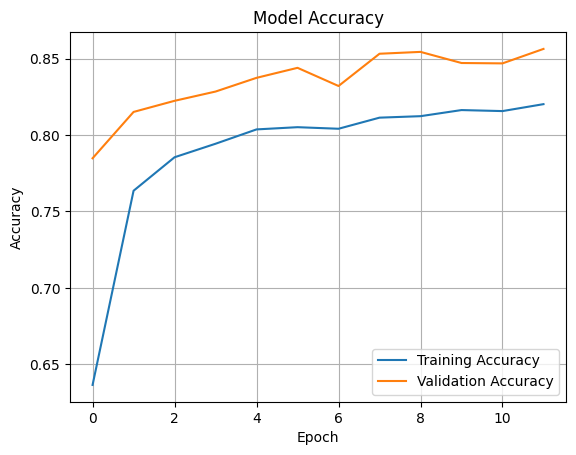

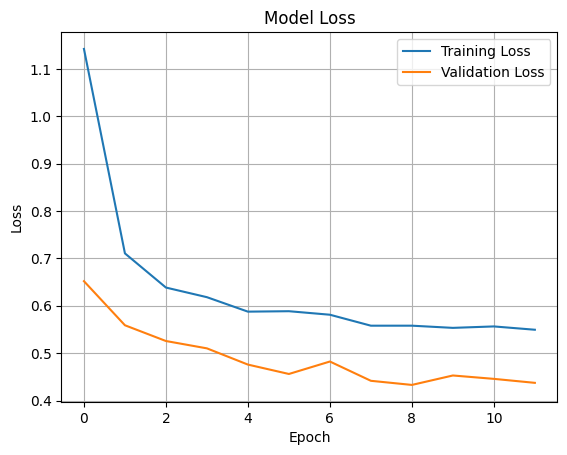

In [ ]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/plant_disease_project/model/plant_disease_model.h5')
print("Model saved successfully.")

In [ ]:
from tensorflow.keras.models import load_model

# Load the best saved model
model = load_model('/content/drive/MyDrive/plant_disease_project/model/best_model.h5')


In [ ]:
import numpy as np
import cv2

img_path = '/content/drive/MyDrive/plant_disease_project/test_images/tomato2.jpg'
img = cv2.imread(img_path)
img = cv2.resize(img, (img_size, img_size))
img = img / 255.0
img = np.expand_dims(img, axis=0)

prediction = model.predict(img)
predicted_class = np.argmax(prediction)
class_names = list(train_generator.class_indices.keys())

print("Predicted class:", class_names[predicted_class])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted class: Tomato_Late_blight
